In [1]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import MiniBatchKMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

# Load datasets
investors_df = pd.read_csv('cleaned_openvc.csv')
ideas_df = pd.read_csv('cleaned_ideas.csv')

# Fill NaN values with an empty string
ideas_df['idea_description'] = ideas_df['idea_description'].fillna("")

# Preprocess the text
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub(r'\W+', ' ', text)  # Remove punctuation
    words = text.lower().split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Lemmatize and remove stopwords
    return words

# Prepare data for Word2Vec training
investment_sentences = investors_df['Investment thesis'].apply(preprocess_text).tolist()
idea_sentences = ideas_df['idea_description'].apply(preprocess_text).tolist()

# Combine sentences from both datasets
all_sentences = investment_sentences + idea_sentences

# Train Word2Vec model
model = Word2Vec(sentences=all_sentences, vector_size=200, window=10, min_count=5, workers=4)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/camellia/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/camellia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Function to compute average word vectors for a given text
def compute_text_embedding(text, model):
    words = preprocess_text(text)
    valid_words = [model.wv[word] for word in words if word in model.wv]
    if valid_words:
        return np.mean(valid_words, axis=0)
    else:
        return np.zeros(model.vector_size)

# Compute embeddings for investment thesis and idea descriptions
investors_embeddings = investors_df['Investment thesis'].apply(lambda x: compute_text_embedding(x, model))
ideas_embeddings = ideas_df['idea_description'].apply(lambda x: compute_text_embedding(x, model))

# Convert to DataFrame for easy manipulation
investors_embeddings_df = pd.DataFrame(investors_embeddings.tolist())
ideas_embeddings_df = pd.DataFrame(ideas_embeddings.tolist())

In [3]:
# Clustering
n_clusters = 5  # Define the number of clusters
kmeans_investors = MiniBatchKMeans(n_clusters=n_clusters)
investors_clusters = kmeans_investors.fit_predict(investors_embeddings_df)

kmeans_ideas = MiniBatchKMeans(n_clusters=n_clusters)
ideas_clusters = kmeans_ideas.fit_predict(ideas_embeddings_df)

# Evaluate clustering performance
investors_silhouette = silhouette_score(investors_embeddings_df, investors_clusters)
investors_davies_bouldin = davies_bouldin_score(investors_embeddings_df, investors_clusters)

ideas_silhouette = silhouette_score(ideas_embeddings_df, ideas_clusters)
ideas_davies_bouldin = davies_bouldin_score(ideas_embeddings_df, ideas_clusters)

print("Investors Silhouette Score:", investors_silhouette)
print("Investors Davies-Bouldin Index:", investors_davies_bouldin)
print("Ideas Silhouette Score:", ideas_silhouette)
print("Ideas Davies-Bouldin Index:", ideas_davies_bouldin)

/Users/camellia/anaconda3/envs/class/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Investors Silhouette Score: 0.45542427672868274
Investors Davies-Bouldin Index: 0.6344147531248985
Ideas Silhouette Score: 0.43270142583732685
Ideas Davies-Bouldin Index: 0.5876909577965418


/Users/camellia/anaconda3/envs/class/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [4]:
#Clustering with Agglomerative Clustering
agg_investors = AgglomerativeClustering(n_clusters=n_clusters)
investors_agg_clusters = agg_investors.fit_predict(investors_embeddings_df)

agg_ideas = AgglomerativeClustering(n_clusters=n_clusters)
ideas_agg_clusters = agg_ideas.fit_predict(ideas_embeddings_df)

# Evaluate clustering performance for Agglomerative Clustering
investors_agg_silhouette = silhouette_score(investors_embeddings_df, investors_agg_clusters)
investors_agg_davies_bouldin = davies_bouldin_score(investors_embeddings_df, investors_agg_clusters)

ideas_agg_silhouette = silhouette_score(ideas_embeddings_df, ideas_agg_clusters)
ideas_agg_davies_bouldin = davies_bouldin_score(ideas_embeddings_df, ideas_agg_clusters)

print("Investors Agglomerative Silhouette Score:", investors_agg_silhouette)
print("Investors Agglomerative Davies-Bouldin Index:", investors_agg_davies_bouldin)
print("Ideas Agglomerative Silhouette Score:", ideas_agg_silhouette)
print("Ideas Agglomerative Davies-Bouldin Index:", ideas_agg_davies_bouldin)

Investors Agglomerative Silhouette Score: 0.4768862019353042
Investors Agglomerative Davies-Bouldin Index: 0.5038976718281399
Ideas Agglomerative Silhouette Score: 0.5164275354013751
Ideas Agglomerative Davies-Bouldin Index: 0.32590505054188373


In [5]:
# Clustering with optimized DBSCAN
dbscan_investors = DBSCAN(eps=0.3, min_samples=4)  # Adjusted parameters
investors_dbscan_clusters = dbscan_investors.fit_predict(investors_embeddings_df)

dbscan_ideas = DBSCAN(eps=0.3, min_samples=4)  # Adjusted parameters
ideas_dbscan_clusters = dbscan_ideas.fit_predict(ideas_embeddings_df)

# Evaluate clustering performance for DBSCAN
investors_dbscan_silhouette = silhouette_score(investors_embeddings_df, investors_dbscan_clusters) if len(set(investors_dbscan_clusters)) > 1 else -1
investors_dbscan_davies_bouldin = davies_bouldin_score(investors_embeddings_df, investors_dbscan_clusters) if len(set(investors_dbscan_clusters)) > 1 else -1

ideas_dbscan_silhouette = silhouette_score(ideas_embeddings_df, ideas_dbscan_clusters) if len(set(ideas_dbscan_clusters)) > 1 else -1
ideas_dbscan_davies_bouldin = davies_bouldin_score(ideas_embeddings_df, ideas_dbscan_clusters) if len(set(ideas_dbscan_clusters)) > 1 else -1

print("Investors DBSCAN Silhouette Score:", investors_dbscan_silhouette)
print("Investors DBSCAN Davies-Bouldin Index:", investors_dbscan_davies_bouldin)
print("Ideas DBSCAN Silhouette Score:", ideas_dbscan_silhouette)
print("Ideas DBSCAN Davies-Bouldin Index:", ideas_dbscan_davies_bouldin)

Investors DBSCAN Silhouette Score: 0.8491761412897589
Investors DBSCAN Davies-Bouldin Index: 0.3288986221275473
Ideas DBSCAN Silhouette Score: 0.49480569930024443
Ideas DBSCAN Davies-Bouldin Index: 4.111001056923679


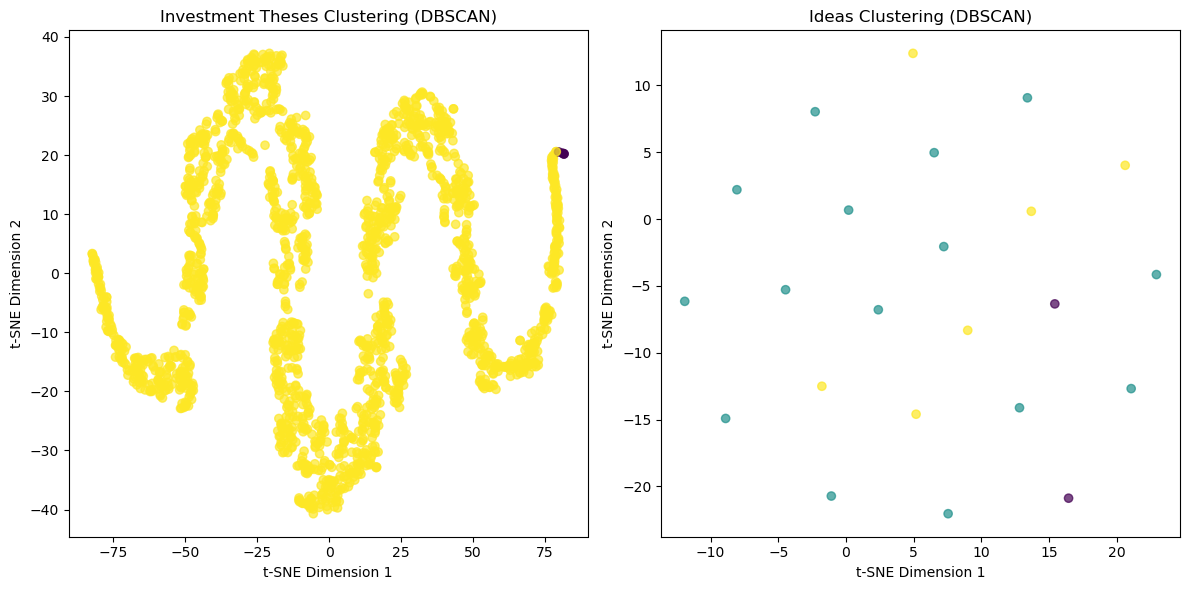

In [8]:
# Investors t-SNE
tsne_investors = TSNE(n_components=2, random_state=0, perplexity=perplexity_value)
investors_embeddings_2d = tsne_investors.fit_transform(investors_embeddings_df)

# Ideas t-SNE
tsne_ideas = TSNE(n_components=2, random_state=0, perplexity=perplexity_value)
ideas_embeddings_2d = tsne_ideas.fit_transform(ideas_embeddings_df)

# Visualization
plt.figure(figsize=(12, 6))

# Plot DBSCAN results for investors
plt.subplot(1, 2, 1)
plt.scatter(investors_embeddings_2d[:, 0], investors_embeddings_2d[:, 1], c=investors_dbscan_clusters, cmap='viridis', marker='o', alpha=0.7)
plt.title('Investment Theses Clustering (DBSCAN)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

# Plot DBSCAN results for ideas
plt.subplot(1, 2, 2)
plt.scatter(ideas_embeddings_2d[:, 0], ideas_embeddings_2d[:, 1], c=ideas_dbscan_clusters, cmap='viridis', marker='o', alpha=0.7)
plt.title('Ideas Clustering (DBSCAN)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')

plt.tight_layout()
plt.show()

In [10]:
# Compute cosine similarity between each idea embedding and each investor's investment thesis embedding
def compute_cosine_similarity(ideas_embeddings_df, investors_embeddings_df):
    cosine_similarities = cosine_similarity(ideas_embeddings_df, investors_embeddings_df)
    return cosine_similarities

# Compute similarity scores
cosine_similarities = compute_cosine_similarity(ideas_embeddings_df, investors_embeddings_df)

# Convert to DataFrame for easy interpretation (rows represent ideas, columns represent investors)
cosine_similarity_df = pd.DataFrame(cosine_similarities, columns=investors_df['Investor name'], index=ideas_df['idea_description'])

# Display the cosine similarity scores between each idea and investor
print(cosine_similarity_df)

# If you want to get the most similar investor for each idea
def recommend_investors_for_ideas(cosine_similarity_df, top_n=5):
    # For each idea, find the top N most similar investors
    recommended_investors = {}
    for idea in cosine_similarity_df.index:
        top_investors = cosine_similarity_df.loc[idea].nlargest(top_n)
        recommended_investors[idea] = top_investors
    return recommended_investors

# Get top 5 recommended investors for each idea
recommended_investors = recommend_investors_for_ideas(cosine_similarity_df, top_n=5)

# Display recommended investors for each idea
for idea, investors in recommended_investors.items():
    print(f"Recommended investors for the idea: '{idea}'")
    print(investors)
    print("\n")


Investor name                                       3TS Capital Partners  \
idea_description                                                           
An organizer system that you install in handbag...              0.999949   
A business that does balloon animals for corpor...              0.999905   
                                                                0.000000   
I'm building a global innovation platform that ...              0.999982   
sharikat tasnae eilajat lilkilab khaliatan min ...              0.999840   
A company that makes an app to stop food waste ...              0.999969   
a business for tourists that uses a QR code to ...              0.999977   
A lemonade stand outside event venues to sell t...              0.999732   
A mems small satellite propulsion system for ma...              0.999947   
BlockLenses are UV blocking daily-wear contact ...              0.999928   
Mainstream air transportation with low carbon e...              0.999760   
Digital mark

In [11]:
from sklearn.neighbors import NearestNeighbors

# Initialize KNN model (using cosine distance)
knn = NearestNeighbors(n_neighbors=5, metric='cosine', algorithm='brute')

# Fit the KNN model on the investors' embeddings
knn.fit(investors_embeddings_df)

# Find the 5 nearest neighbors for each idea
distances, indices = knn.kneighbors(ideas_embeddings_df)

# Prepare the results in a user-friendly way
recommended_investors_knn = {}
for idx, idea in enumerate(ideas_df['idea_description']):
    # Get the top 5 most similar investors for each idea
    top_investors = investors_df['Investor name'].iloc[indices[idx]].tolist()
    recommended_investors_knn[idea] = top_investors

# Display the top investors for each idea
for idea, investors in recommended_investors_knn.items():
    print(f"Recommended investors for the idea: '{idea}'")
    print(investors)
    print("\n")


Recommended investors for the idea: 'An organizer system that you install in handbags to make it easier and faster to find things.'
['New Orleans BioInnovation Center', 'True Growth Capital', 'Dreamers VC', 'Telstra Ventures', 'Infinium Partners']


Recommended investors for the idea: 'A business that does balloon animals for corporate events and concerts. '
['KK39 Ventures', 'Elevar Equity', 'Hampton Capital', 'PT Saratoga Investama Sedaya Tbk', 'C2 Capital']


Recommended investors for the idea: ''
['Ganas Ventures', 'Palindrome Capital', 'Movens VC', 'Alliance For Impact (AFI)', 'AngelHub']


Recommended investors for the idea: 'I'm building a global innovation platform that allows entrepreneurs to build and launch their startups quickly. Using an AI-powered backend, founders can use a single sentence to create an enhanced lean canvas, validation roadmap, branding wheel, and more in about 90 seconds. We will then score the startup ideas and teams and connect the best ones to curated

In [15]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Function to compute cosine similarity matrix for a set of idea and investor embeddings
def compute_cosine_similarity_matrix(ideas_embeddings_df, investors_embeddings_df):
    return cosine_similarity(ideas_embeddings_df, investors_embeddings_df)

# Cross-validation function to evaluate cosine similarity
def cross_validate_cosine_similarity(ideas_embeddings_df, investors_embeddings_df, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    mae_scores = []
    mse_scores = []
    
    # Perform K-fold cross-validation
    for train_index, test_index in kf.split(ideas_embeddings_df):
        # Split data into train and test
        train_ideas_embeddings = ideas_embeddings_df.iloc[train_index]
        test_ideas_embeddings = ideas_embeddings_df.iloc[test_index]
        
        # Compute similarity matrix for train and test
        train_similarity_matrix = compute_cosine_similarity_matrix(train_ideas_embeddings, investors_embeddings_df)
        test_similarity_matrix = compute_cosine_similarity_matrix(test_ideas_embeddings, investors_embeddings_df)
        
        # Now calculate the mean cosine similarity for the test ideas (one per row)
        # We will take the average similarity across all investors for each test idea
        test_mean_similarity = test_similarity_matrix.mean(axis=1)
        
        # Similarly, we compute the predicted similarity for the test ideas using the train set
        train_mean_similarity = train_similarity_matrix.mean(axis=1)
        
        # Compare the test mean similarity with the predicted similarity from the train set
        mae = mean_absolute_error(test_mean_similarity, train_mean_similarity[:len(test_mean_similarity)])
        mse = mean_squared_error(test_mean_similarity, train_mean_similarity[:len(test_mean_similarity)])
        
        mae_scores.append(mae)
        mse_scores.append(mse)
    
    return np.mean(mae_scores), np.mean(mse_scores)

# Run cross-validation for cosine similarity
mae, mse = cross_validate_cosine_similarity(ideas_embeddings_df, investors_embeddings_df, k=5)

# Print results
print(f"Cross-Validation Mean Absolute Error (MAE): {mae:.4f}")
print(f"Cross-Validation Mean Squared Error (MSE): {mse:.4f}")



Cross-Validation Mean Absolute Error (MAE): 0.2197
Cross-Validation Mean Squared Error (MSE): 0.2193
